Cargando datos...
Total generaciones cargadas: 6000
Total ratings cargados: 6000
Total registros unidos para análisis: 6000

RESUMEN EJECUTIVO: RENDIMIENTO POR MODELO
                        f1_score  precision  correct_selection_count  \
llm                                                                    
gpt-5-chat                0.2221     0.2233                   0.8930   
DeepSeek-V3.1             0.2000     0.2021                   0.8085   
gpt-4o                    0.1982     0.2025                   0.8102   
gpt-35-turbo              0.1812     0.1821                   0.7286   
Llama-3.3-70B-Instruct    0.1413     0.1500                   0.6002   

                       was_improved  delta_total  novelty  N_Samples  
llm                                                                   
gpt-5-chat                   60.02%       0.0084   5.6545       1193  
DeepSeek-V3.1                60.51%       0.1403   5.2508       1066  
gpt-4o                       51.59%      -0.

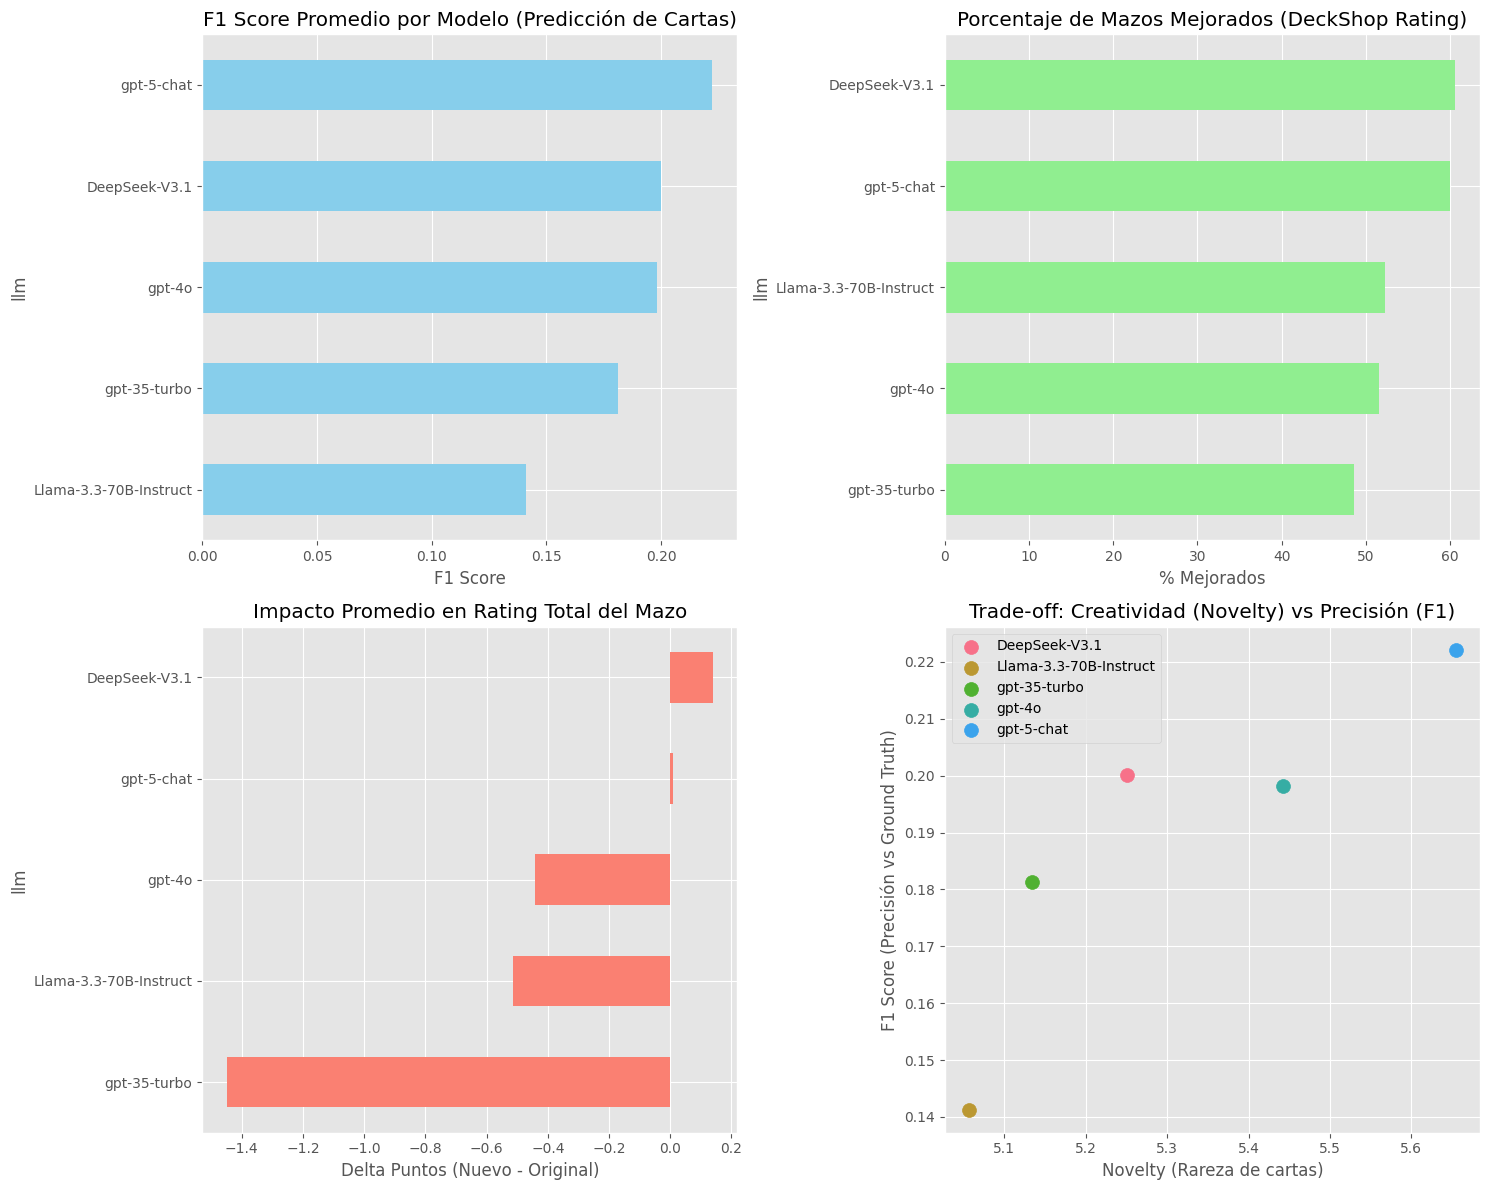


Análisis completado.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

plt.style.use('ggplot')
sns.set_palette("husl")

# ============================================================================
# 1. CARGA Y FUSIÓN DE DATOS
# ============================================================================

def load_and_merge_data(gen_path, ratings_path):
    """
    Carga los archivos de generación y ratings, y los une por execution_id.
    """
    print("Cargando datos...")
    
    df_gen = pd.read_json(gen_path, lines=True)
    
    df_ratings = pd.read_json(ratings_path, lines=True)
    
    df_merged = pd.merge(df_gen, df_ratings, on='execution_id', how='inner')
    
    print(f"Total generaciones cargadas: {len(df_gen)}")
    print(f"Total ratings cargados: {len(df_ratings)}")
    print(f"Total registros unidos para análisis: {len(df_merged)}")
    
    return df_merged

GENERATIONS_FILE = '../results/generations_20251128_082528.jsonl'
RATINGS_FILE = '../rating/deck_shop_ratings_20251128_145534.jsonl'

df_main = load_and_merge_data(GENERATIONS_FILE, RATINGS_FILE)

# ============================================================================
# 2. PREPROCESAMIENTO Y CÁLCULO DE MÉTRICAS BÁSICAS
# ============================================================================

df_valid = df_main[df_main['is_parsed'] == True].copy()

CARDS_TO_PREDICT = 4

df_valid['precision'] = df_valid['correct_selection_count'] / CARDS_TO_PREDICT
df_valid['recall'] = df_valid['correct_selection_count'] / CARDS_TO_PREDICT
df_valid['f1_score'] = 2 * (df_valid['precision'] * df_valid['recall']) / (df_valid['precision'] + df_valid['recall'])
df_valid['f1_score'] = df_valid['f1_score'].fillna(0)

def get_selection_list(row):
    if isinstance(row['parsed_selection'], dict) and 'selection' in row['parsed_selection']:
        return row['parsed_selection']['selection']
    elif isinstance(row['parsed_selection'], list):
        return row['parsed_selection']
    return []

df_valid['selected_cards'] = df_valid.apply(get_selection_list, axis=1)

# ============================================================================
# 3. ANÁLISIS DE RATINGS (Deck Shop)
# ============================================================================

def extract_scores(row):
    scores_new = row['scores_new'] if isinstance(row['scores_new'], dict) else {}
    scores_orig = row['scores_original'] if isinstance(row['scores_original'], dict) else {}
    
    return pd.Series({
        'new_attack': scores_new.get('Attack', 0),
        'new_defense': scores_new.get('Defense', 0),
        'new_synergy': scores_new.get('Synergy', 0),
        'new_versatility': scores_new.get('Versatility', 0),
        'new_f2p': scores_new.get('F2P score', 0),
        'orig_attack': scores_orig.get('Attack', 0),
        'orig_defense': scores_orig.get('Defense', 0),
        'orig_synergy': scores_orig.get('Synergy', 0),
        'orig_versatility': scores_orig.get('Versatility', 0),
        'orig_f2p': scores_orig.get('F2P score', 0)
    })

score_cols = df_valid.apply(extract_scores, axis=1)
df_valid = pd.concat([df_valid, score_cols], axis=1)

df_valid['delta_attack'] = df_valid['new_attack'] - df_valid['orig_attack']
df_valid['delta_defense'] = df_valid['new_defense'] - df_valid['orig_defense']
df_valid['delta_synergy'] = df_valid['new_synergy'] - df_valid['orig_synergy']
df_valid['delta_versatility'] = df_valid['new_versatility'] - df_valid['orig_versatility']
df_valid['delta_total'] = df_valid['total_new'] - df_valid['total_original']

# ============================================================================
# 4. CÁLCULO DE DIVERSIDAD Y NOVELTY (Adaptado)
# ============================================================================

all_recommendations = [card for sublist in df_valid['selected_cards'] for card in sublist]
card_counts = pd.Series(all_recommendations).value_counts()
total_recommendations = len(all_recommendations)

def calculate_novelty(cards):
    if not cards: return 0
    novelty_score = 0
    for card in cards:
        p = card_counts.get(card, 0) / total_recommendations
        if p > 0:
            novelty_score += -np.log2(p)
    return novelty_score / len(cards)

df_valid['novelty'] = df_valid['selected_cards'].apply(calculate_novelty)

unique_cards_recommended = len(set(all_recommendations))
TOTAL_GAME_CARDS = 110 
coverage = (unique_cards_recommended / TOTAL_GAME_CARDS) * 100

# ============================================================================
# 5. GENERACIÓN DE RESÚMENES
# ============================================================================

print("\n" + "="*80)
print("RESUMEN EJECUTIVO: RENDIMIENTO POR MODELO")
print("="*80)

summary = df_valid.groupby('llm').agg({
    'f1_score': 'mean',
    'precision': 'mean',
    'correct_selection_count': 'mean',
    'was_improved': 'mean',
    'delta_total': 'mean',
    'novelty': 'mean',
    'execution_id': 'count'
}).rename(columns={'execution_id': 'N_Samples'})

summary['was_improved'] = (summary['was_improved'] * 100).round(2).astype(str) + '%'
summary = summary.round(4).sort_values('f1_score', ascending=False)

print(summary)

print("\n" + "="*80)
print("ANÁLISIS DE ERRORES DE PARSEO")
print("="*80)
parse_summary = df_main.groupby('llm')['is_parsed'].agg(['count', 'sum', 'mean'])
parse_summary['error_rate'] = (1 - parse_summary['mean']) * 100
parse_summary.columns = ['Total', 'Parsed_OK', 'Success_Rate', 'Error_Rate %']
print(parse_summary)

# ============================================================================
# 6. VISUALIZACIÓN (Ejemplos clave)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0,0]
f1_data = df_valid.groupby('llm')['f1_score'].mean().sort_values()
f1_data.plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('F1 Score Promedio por Modelo (Predicción de Cartas)')
ax1.set_xlabel('F1 Score')

ax2 = axes[0,1]
imp_data = summary['was_improved'].str.rstrip('%').astype(float).sort_values()
imp_data.plot(kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Porcentaje de Mazos Mejorados (DeckShop Rating)')
ax2.set_xlabel('% Mejorados')

ax3 = axes[1,0]
delta_data = df_valid.groupby('llm')['delta_total'].mean().sort_values()
delta_data.plot(kind='barh', ax=ax3, color='salmon')
ax3.set_title('Impacto Promedio en Rating Total del Mazo')
ax3.set_xlabel('Delta Puntos (Nuevo - Original)')

ax4 = axes[1,1]
perf_novelty = df_valid.groupby('llm')[['f1_score', 'novelty']].mean()
for idx, row in perf_novelty.iterrows():
    ax4.scatter(row['novelty'], row['f1_score'], s=100, label=idx)
ax4.set_title('Trade-off: Creatividad (Novelty) vs Precisión (F1)')
ax4.set_xlabel('Novelty (Rareza de cartas)')
ax4.set_ylabel('F1 Score (Precisión vs Ground Truth)')
ax4.legend()

plt.tight_layout()
plt.show()

print("\nAnálisis completado.")

Cargando ../results/generations_20251128_082528.jsonl...
Cargando ../rating/deck_shop_ratings_20251128_145534.jsonl...
Fusionando datasets...
Registros en Generaciones: 6000
Registros en Ratings: 6000
Registros totales para análisis: 6000
Extrayendo información de cartas y respuestas (Lógica Mejorada)...
Registros válidos recuperados: 5767 de 6000
Calculando métricas ML (F1, Precision, Recall)...
Procesando scores de Deck Shop...
Calculando métricas de diversidad y creatividad...

RESUMEN FINAL POR MODELO
                        f1_score  precision  Avg_Hits  was_improved  \
llm                                                                   
gpt-5-chat                0.2221     0.2233    0.8930        0.6002   
DeepSeek-V3.1             0.2000     0.2021    0.8085        0.6051   
gpt-4o                    0.1984     0.2025    0.8102        0.5164   
gpt-35-turbo              0.1812     0.1821    0.7286        0.4861   
Llama-3.3-70B-Instruct    0.1413     0.1500    0.6002        0.

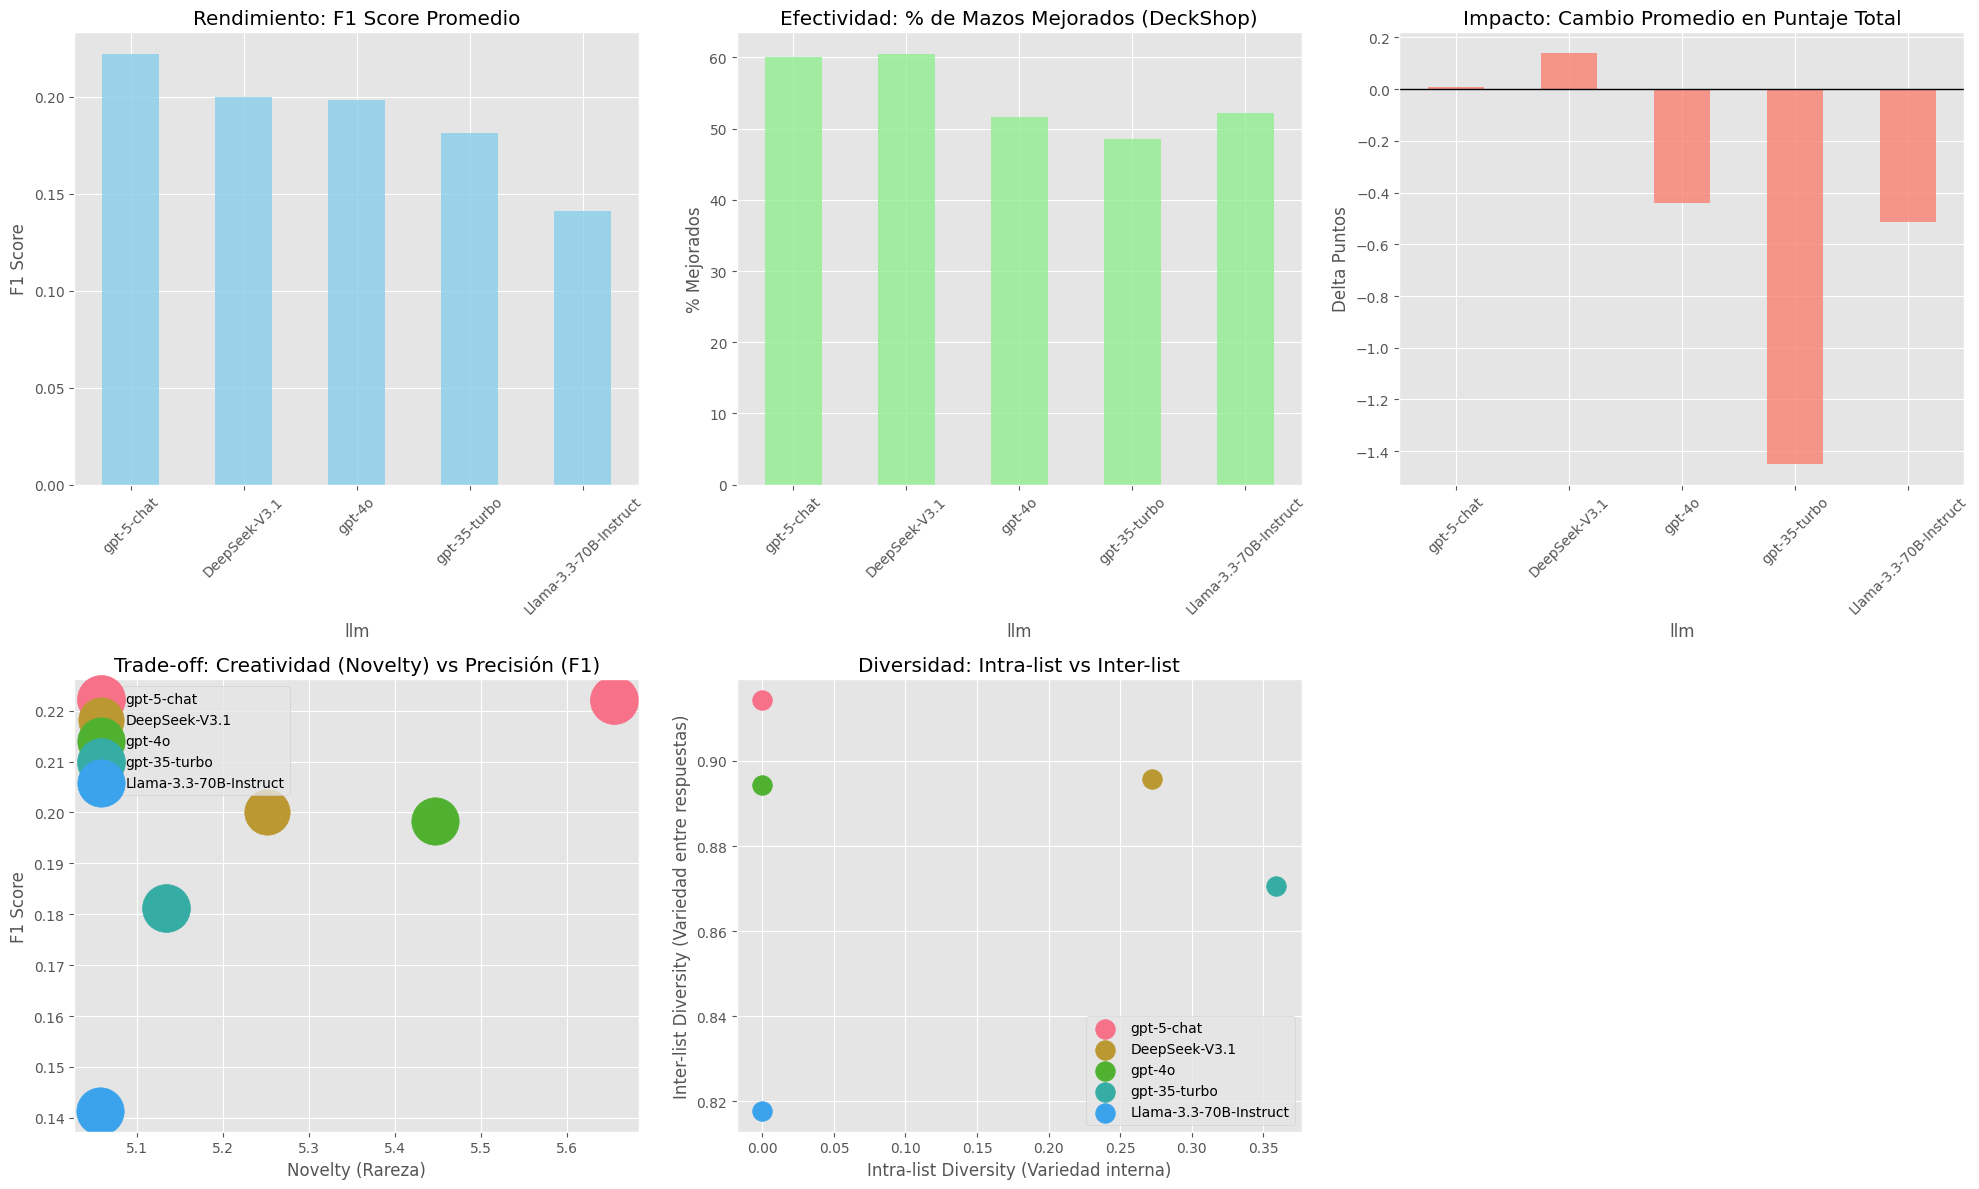


Análisis completado con éxito.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from itertools import combinations

plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# ============================================================================
# 1. CARGA Y FUSIÓN DE DATOS
# ============================================================================

def load_and_merge_data(gen_path, ratings_path):
    print(f"Cargando {gen_path}...")
    df_gen = pd.read_json(gen_path, lines=True)
    
    print(f"Cargando {ratings_path}...")
    df_ratings = pd.read_json(ratings_path, lines=True)
    
    print("Fusionando datasets...")
    df_merged = pd.merge(df_gen, df_ratings, on='execution_id', how='inner')
    
    print(f"Registros en Generaciones: {len(df_gen)}")
    print(f"Registros en Ratings: {len(df_ratings)}")
    print(f"Registros totales para análisis: {len(df_merged)}")
    
    return df_merged

GENERATIONS_FILE = '../results/generations_20251128_082528.jsonl'
RATINGS_FILE = '../rating/deck_shop_ratings_20251128_145534.jsonl'

df_main = load_and_merge_data(GENERATIONS_FILE, RATINGS_FILE)

# ============================================================================
# 2. PREPROCESAMIENTO Y EXTRACCIÓN DE DATOS
# ============================================================================

def safe_json_parse(json_str):
    if isinstance(json_str, dict):
        return json_str
    try:
        return json.loads(json_str)
    except:
        return {}

def extract_card_data(row):
    existing_parse = row.get('parsed_selection')
    
    if isinstance(existing_parse, dict) and 'selection' in existing_parse:
        selection = existing_parse['selection']
    elif isinstance(existing_parse, list):
        selection = existing_parse
    else:
        selection = []

    if not selection:
        parsed = safe_json_parse(row.get('raw_response', '{}'))
        if isinstance(parsed, dict):
            if 'selection' in parsed: selection = parsed['selection']
            elif 'seleccion' in parsed: selection = parsed['seleccion']
            elif 'cards' in parsed: selection = parsed['cards']

            elif len(parsed) == 1 and isinstance(list(parsed.values())[0], list):
                selection = list(parsed.values())[0]
        elif isinstance(parsed, list):
            selection = parsed

    roles = []
    costos = []
    parsed_meta = safe_json_parse(row.get('raw_response', '{}'))
    if isinstance(parsed_meta, dict) and 'detail' in parsed_meta and isinstance(parsed_meta['detail'], list):
        for card in parsed_meta['detail']:
            roles.append(card.get('role', ''))
            costos.append(card.get('elixir_cost', 0))
            
    return pd.Series({
        'extracted_selection': selection,
        'extracted_roles': roles,
        'extracted_costs': costos
    })

print("Extrayendo información de cartas y respuestas (Lógica Mejorada)...")
card_data = df_main.apply(extract_card_data, axis=1)

cols_to_drop = [c for c in card_data.columns if c in df_main.columns]
df_main = df_main.drop(columns=cols_to_drop)
df_main = pd.concat([df_main, card_data], axis=1)

df_valid = df_main[df_main['extracted_selection'].apply(len) > 0].copy()
print(f"Registros válidos recuperados: {len(df_valid)} de {len(df_main)}")

# ============================================================================
# 3. CÁLCULO DE MÉTRICAS DE CLASIFICACIÓN (Precision, Recall, F1)
# ============================================================================

def calculate_ml_metrics(row):
    tp = row['correct_selection_count']
    n_predicted = len(row['extracted_selection'])
    n_actual = len(row['deleted_cards']) if isinstance(row['deleted_cards'], list) else 4
    precision = tp / n_predicted if n_predicted > 0 else 0
    recall = tp / n_actual if n_actual > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return pd.Series({
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

print("Calculando métricas ML (F1, Precision, Recall)...")
ml_metrics = df_valid.apply(calculate_ml_metrics, axis=1)
df_valid = pd.concat([df_valid, ml_metrics], axis=1)

# ============================================================================
# 4. ANÁLISIS DE DECK SHOP RATINGS (Métricas de Negocio)
# ============================================================================

def extract_scores(row):
    """Aplana los diccionarios de scores"""
    scores_new = row['scores_new'] if isinstance(row['scores_new'], dict) else {}
    scores_orig = row['scores_original'] if isinstance(row['scores_original'], dict) else {}
    
    return pd.Series({
        'new_attack': scores_new.get('Attack', 0),
        'new_defense': scores_new.get('Defense', 0),
        'new_synergy': scores_new.get('Synergy', 0),
        'new_versatility': scores_new.get('Versatility', 0),
        'orig_attack': scores_orig.get('Attack', 0),
        'orig_defense': scores_orig.get('Defense', 0),
        'orig_synergy': scores_orig.get('Synergy', 0),
        'orig_versatility': scores_orig.get('Versatility', 0)
    })

print("Procesando scores de Deck Shop...")
score_cols = df_valid.apply(extract_scores, axis=1)
df_valid = pd.concat([df_valid, score_cols], axis=1)

df_valid['delta_total'] = df_valid['total_new'] - df_valid['total_original']
df_valid['delta_synergy'] = df_valid['new_synergy'] - df_valid['orig_synergy']

# ============================================================================
# 5. CÁLCULO DE DIVERSIDAD, NOVELTY Y COVERAGE
# ============================================================================

print("Calculando métricas de diversidad y creatividad...")

all_cards_recommended = [card for sublist in df_valid['extracted_selection'] for card in sublist]
card_counts = Counter(all_cards_recommended)
total_recs = len(all_cards_recommended)

card_prob = {k: v / total_recs for k, v in card_counts.items()}

def calculate_novelty(cards):
    if not cards: return 0
    novelty_score = 0
    for card in cards:
        p = card_prob.get(card, 1e-9)
        novelty_score += -np.log2(p)
    return novelty_score / len(cards)

df_valid['novelty'] = df_valid['extracted_selection'].apply(calculate_novelty)

def calculate_intra_diversity(row):
    roles = row['extracted_roles']
    costs = [float(c) for c in row['extracted_costs'] if str(c).replace('.','').isdigit()]
    if not roles or not costs: return 0
    role_div = len(set(roles)) / len(roles)
    cost_div = np.std(costs) if len(costs) > 1 else 0
    return (role_div + min(cost_div, 2)/2) / 2

df_valid['intra_list_diversity'] = df_valid.apply(calculate_intra_diversity, axis=1)

def jaccard_dist(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    if not s1 and not s2: return 0
    return 1 - len(s1.intersection(s2)) / len(s1.union(s2))

model_diversity_metrics = {}

for model in df_valid['llm'].unique():
    sub_df = df_valid[df_valid['llm'] == model]
    
    unique_model = set([c for sublist in sub_df['extracted_selection'] for c in sublist])
    unique_total = set(card_counts.keys())
    coverage = len(unique_model) / len(unique_total)
    
    sample_recs = sub_df['extracted_selection'].sample(min(100, len(sub_df))).tolist()
    dists = []
    if len(sample_recs) > 1:
        for i, rec1 in enumerate(sample_recs):
            for rec2 in sample_recs[i+1:]:
                dists.append(jaccard_dist(rec1, rec2))
        inter_div = np.mean(dists)
    else:
        inter_div = 0
        
    model_diversity_metrics[model] = {'coverage': coverage, 'inter_list_diversity': inter_div}

# ============================================================================
# 6. GENERACIÓN DE REPORTES Y VISUALIZACIÓN
# ============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL POR MODELO")
print("="*80)

summary = df_valid.groupby('llm').agg({
    'f1_score': 'mean',
    'precision': 'mean',
    'correct_selection_count': 'mean',
    'was_improved': 'mean',
    'delta_total': 'mean',
    'novelty': 'mean',
    'intra_list_diversity': 'mean',
    'execution_id': 'count'
}).rename(columns={'execution_id': 'Samples', 'correct_selection_count': 'Avg_Hits'})

for model, metrics in model_diversity_metrics.items():
    summary.loc[model, 'coverage'] = metrics['coverage']
    summary.loc[model, 'inter_list_diversity'] = metrics['inter_list_diversity']

summary = summary.sort_values('f1_score', ascending=False).round(4)
print(summary)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
summary['f1_score'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Rendimiento: F1 Score Promedio')
ax1.set_ylabel('F1 Score')
ax1.tick_params(axis='x', rotation=45)

ax2 = fig.add_subplot(gs[0, 1])
(summary['was_improved']*100).plot(kind='bar', ax=ax2, color='lightgreen', alpha=0.8)
ax2.set_title('Efectividad: % de Mazos Mejorados (DeckShop)')
ax2.set_ylabel('% Mejorados')
ax2.tick_params(axis='x', rotation=45)

ax3 = fig.add_subplot(gs[0, 2])
summary['delta_total'].plot(kind='bar', ax=ax3, color='salmon', alpha=0.8)
ax3.set_title('Impacto: Cambio Promedio en Puntaje Total')
ax3.set_ylabel('Delta Puntos')
ax3.axhline(0, color='black', linewidth=1)
ax3.tick_params(axis='x', rotation=45)

ax4 = fig.add_subplot(gs[1, 0])
for model in summary.index:
    ax4.scatter(summary.loc[model, 'novelty'], summary.loc[model, 'f1_score'], 
                s=summary.loc[model, 'Samples'], label=model)
ax4.set_title('Trade-off: Creatividad (Novelty) vs Precisión (F1)')
ax4.set_xlabel('Novelty (Rareza)')
ax4.set_ylabel('F1 Score')
ax4.legend()

ax5 = fig.add_subplot(gs[1, 1])
for model in summary.index:
    ax5.scatter(summary.loc[model, 'intra_list_diversity'], 
                summary.loc[model, 'inter_list_diversity'], 
                s=200, label=model)
ax5.set_title('Diversidad: Intra-list vs Inter-list')
ax5.set_xlabel('Intra-list Diversity (Variedad interna)')
ax5.set_ylabel('Inter-list Diversity (Variedad entre respuestas)')
ax5.legend()

plt.tight_layout()
plt.show()

print("\nAnálisis completado con éxito.")


ANÁLISIS GLOBAL DE PROMPTS (Impacto del Contexto en General)
                           delta_total  Success Rate %  f1_score   novelty  \
prompt_type                                                                  
context_multistep_english    -0.426136           55.60  0.185342  5.281394   
context                      -0.463293           53.21  0.189037  5.326018   
context_multistep            -0.466236           55.40  0.190720  5.337224   
context_english              -0.493444           53.85  0.189162  5.298708   

                           Samples  
prompt_type                         
context_multistep_english     1419  
context                       1464  
context_multistep             1417  
context_english               1467  


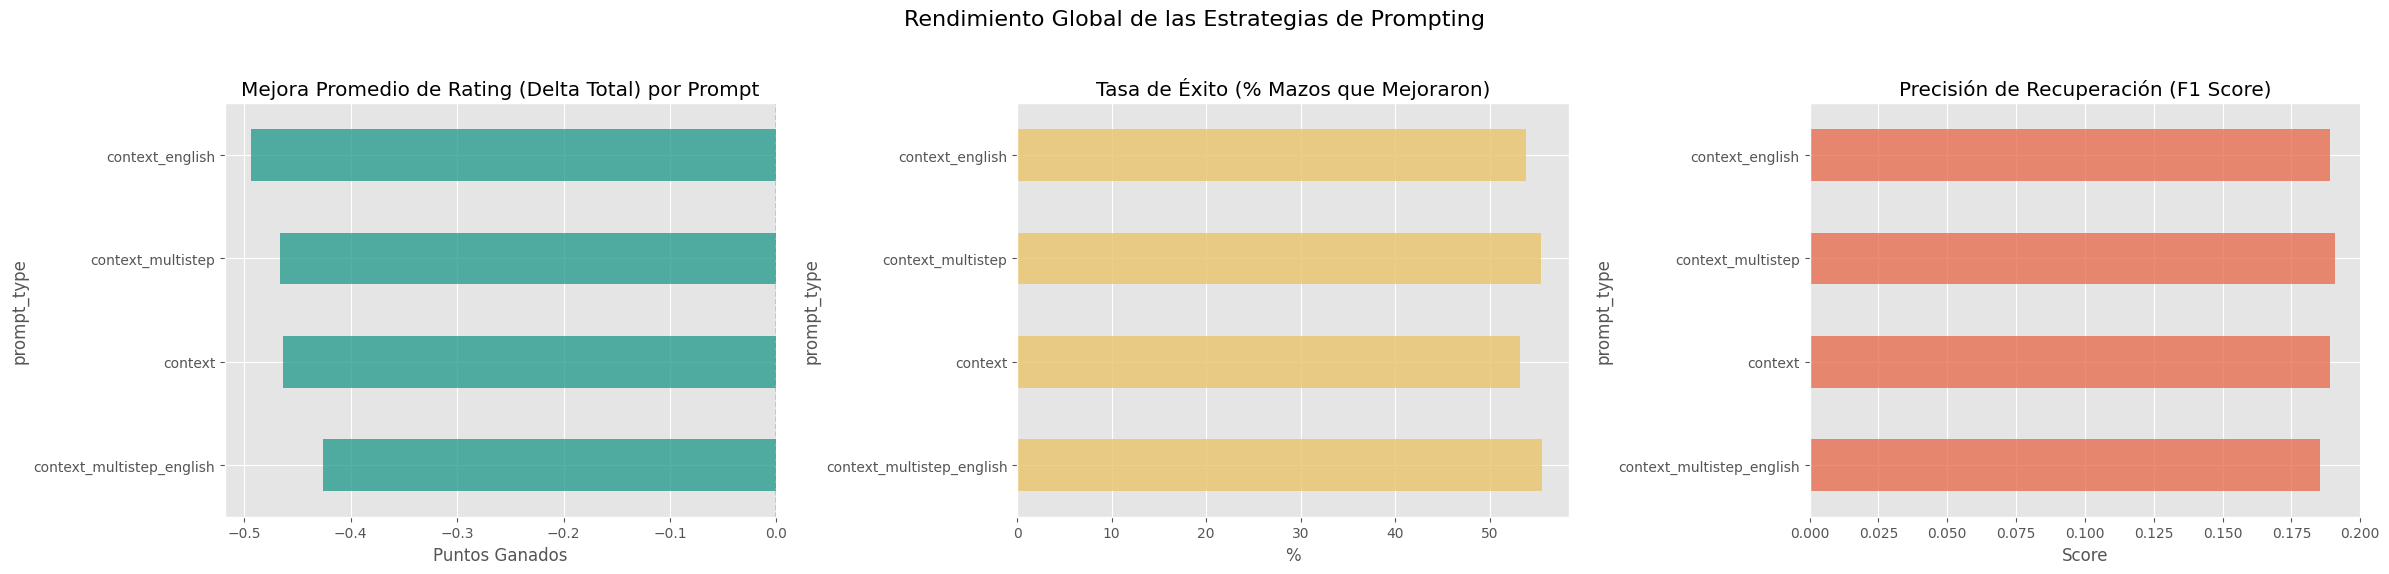

In [16]:
import matplotlib.pyplot as plt

# ==============================================================================
# ANÁLISIS DE RENDIMIENTO POR TIPO DE PROMPT (CONTEXTO)
# ==============================================================================

print("\n" + "="*80)
print("ANÁLISIS GLOBAL DE PROMPTS (Impacto del Contexto en General)")
print("="*80)

prompt_global = df_valid.groupby('prompt_type').agg({
    'delta_total': 'mean',
    'was_improved': 'mean',
    'f1_score': 'mean',
    'novelty': 'mean',
    'execution_id': 'count'
}).rename(columns={'execution_id': 'Samples'})

prompt_global['Success Rate %'] = (prompt_global['was_improved'] * 100).round(2)

prompt_global = prompt_global.sort_values('delta_total', ascending=False)

print(prompt_global[['delta_total', 'Success Rate %', 'f1_score', 'novelty', 'Samples']])

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

prompt_global['delta_total'].plot(kind='barh', ax=axes[0], color='#2a9d8f', alpha=0.8)
axes[0].set_title('Mejora Promedio de Rating (Delta Total) por Prompt')
axes[0].set_xlabel('Puntos Ganados')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1)

prompt_global['Success Rate %'].plot(kind='barh', ax=axes[1], color='#e9c46a', alpha=0.8)
axes[1].set_title('Tasa de Éxito (% Mazos que Mejoraron)')
axes[1].set_xlabel('%')

prompt_global['f1_score'].plot(kind='barh', ax=axes[2], color='#e76f51', alpha=0.8)
axes[2].set_title('Precisión de Recuperación (F1 Score)')
axes[2].set_xlabel('Score')

plt.suptitle('Rendimiento Global de las Estrategias de Prompting', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


ANÁLISIS DE IMPACTO DEL CONTEXTO (PROMPT TYPE)
                                                  f1_score  delta_total  \
llm                    prompt_type                                        
gpt-5-chat             context_multistep          0.227196     0.003390   
                       context                    0.225000     0.077181   
                       context_multistep_english  0.222222    -0.010169   
                       context_english            0.214167    -0.036789   
gpt-4o                 context_multistep          0.208627    -0.388693   
                       context_english            0.198826    -0.457912   
                       context_multistep_english  0.195804    -0.405594   
                       context                    0.190476    -0.514706   
gpt-35-turbo           context_multistep          0.187713    -1.539519   
                       context                    0.182886    -1.408784   
                       context_multistep_english  0.

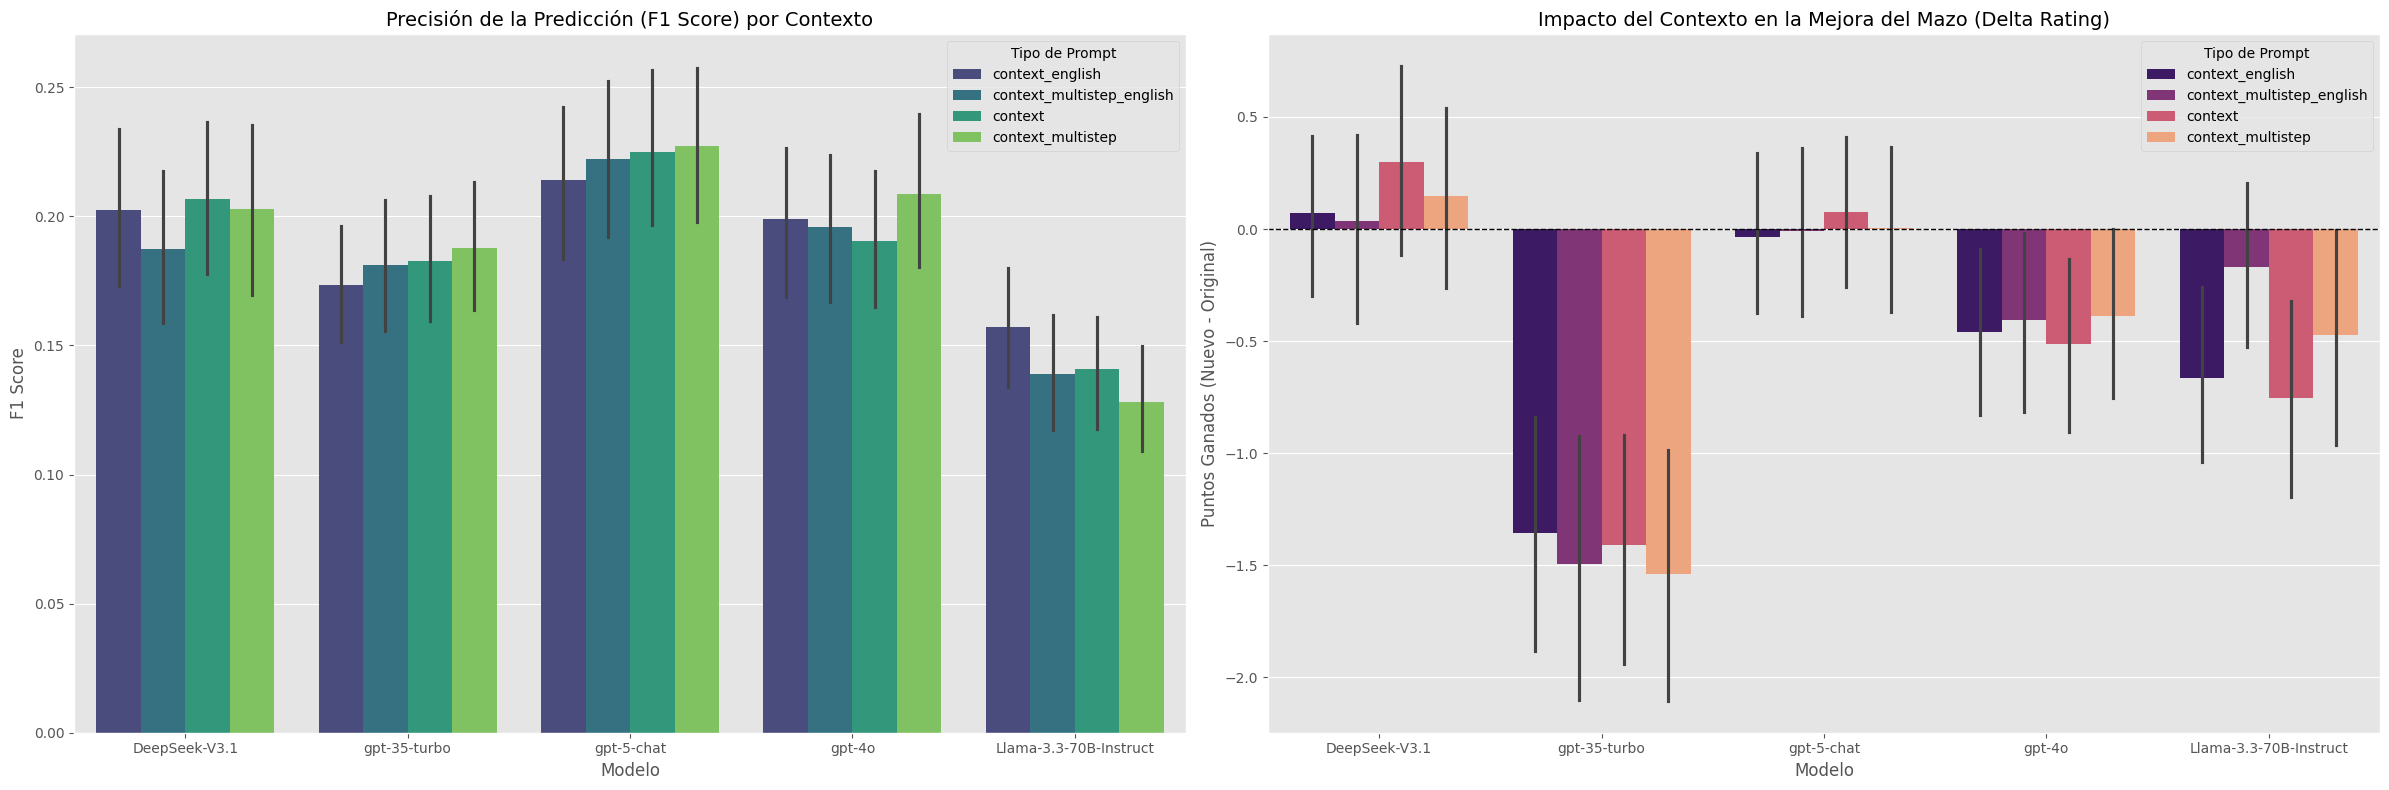


MEJOR CONTEXTO POR MODELO (Basado en Delta Total de DeckShop):
                      llm                prompt_type  delta_total  \
0           DeepSeek-V3.1                    context     0.298182   
1  Llama-3.3-70B-Instruct  context_multistep_english    -0.169065   
2            gpt-35-turbo            context_english    -1.354730   
3                  gpt-4o          context_multistep    -0.388693   
4              gpt-5-chat                    context     0.077181   

   Success Rate %  
0           63.18  
1           56.34  
2           48.48  
3           51.76  
4           60.33  


In [17]:
# ============================================================================
# ANÁLISIS DE RENDIMIENTO POR CONTEXTO (PROMPT_TYPE)
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS DE IMPACTO DEL CONTEXTO (PROMPT TYPE)")
print("="*80)

ctx_summary = df_valid.groupby(['llm', 'prompt_type']).agg({
    'f1_score': 'mean',
    'delta_total': 'mean',
    'was_improved': 'mean',
    'novelty': 'mean',
    'execution_id': 'count'
}).rename(columns={'execution_id': 'Samples'})

ctx_summary['Success Rate %'] = (ctx_summary['was_improved'] * 100).round(2)
ctx_summary = ctx_summary.drop(columns=['was_improved'])

print(ctx_summary.sort_values(['llm', 'f1_score'], ascending=False))

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

sns.barplot(data=df_valid, x='llm', y='f1_score', hue='prompt_type', ax=axes[0], palette='viridis')
axes[0].set_title('Precisión de la Predicción (F1 Score) por Contexto', fontsize=14)
axes[0].set_ylabel('F1 Score')
axes[0].set_xlabel('Modelo')
axes[0].legend(title='Tipo de Prompt')

sns.barplot(data=df_valid, x='llm', y='delta_total', hue='prompt_type', ax=axes[1], palette='magma')
axes[1].set_title('Impacto del Contexto en la Mejora del Mazo (Delta Rating)', fontsize=14)
axes[1].set_ylabel('Puntos Ganados (Nuevo - Original)')
axes[1].set_xlabel('Modelo')
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1].legend(title='Tipo de Prompt')

plt.tight_layout()
plt.show()

print("\nMEJOR CONTEXTO POR MODELO (Basado en Delta Total de DeckShop):")
best_ctx = ctx_summary.reset_index().sort_values(['llm', 'delta_total'], ascending=[True, False])
best_ctx = best_ctx.groupby('llm').first().reset_index()
print(best_ctx[['llm', 'prompt_type', 'delta_total', 'Success Rate %']])

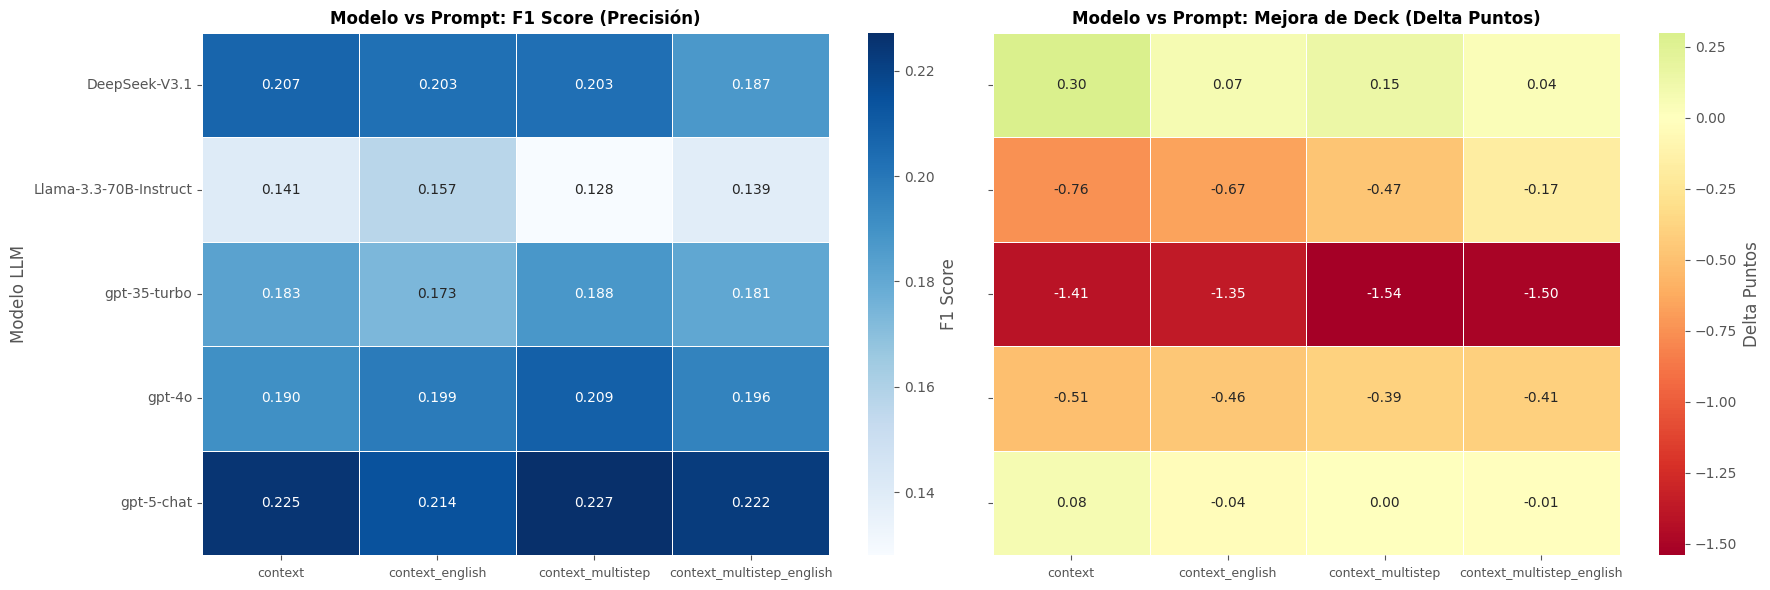

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

f1_matrix = df_valid.pivot_table(
    index='llm', 
    columns='prompt_type', 
    values='f1_score', 
    aggfunc='mean'
)

delta_matrix = df_valid.pivot_table(
    index='llm', 
    columns='prompt_type', 
    values='delta_total', 
    aggfunc='mean'
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Heatmap 1: F1 Score ---
sns.heatmap(
    f1_matrix, 
    annot=True, 
    fmt=".3f", 
    cmap="Blues", 
    linewidths=.5, 
    cbar_kws={'label': 'F1 Score'},
    ax=axes[0]
)
axes[0].set_title('Modelo vs Prompt: F1 Score (Precisión)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Modelo LLM')
axes[0].set_xlabel('')

# --- Heatmap 2: DeckShop Delta ---
sns.heatmap(
    delta_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="RdYlGn", 
    center=0, 
    linewidths=.5,
    cbar_kws={'label': 'Delta Puntos'},
    ax=axes[1]
)
axes[1].set_title('Modelo vs Prompt: Mejora de Deck (Delta Puntos)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=9)    
    ax.tick_params(axis='x', which='major', pad=5)

plt.tight_layout()
plt.show()